##  Step 1 Generate sim_rates

In [61]:
import pandas as pd
import numpy as np
import os

In [62]:
"""
using swap rate to construct DFT curve
"""
corr=pd.read_excel("fwd_rates_correl.xlsx", sheet_name ="change_corr").to_numpy()[1:,1:]
curve = pd.read_excel("values of swaptions_and_bermudan_v4.xlsx", sheet_name ="cms")

In [3]:
from scipy import interpolate, stats, optimize
#fit cubic spline to curve to get other maturities
maturities = np.arange(1, 21)*0.5
cs = interpolate.CubicSpline(curve["tenor"], curve["swap rate"])
cms = np.array(pd.DataFrame({"maturity" : maturities,"rate" : cs(maturities)/100}))
par=cms[:,1]

# boostrap discount prices from par rate
DFT=np.zeros(cms.shape[0])
DFT[0]=1/(1+par[0]/2)
for i in range(1,20):
    DFT[i]=(1-par[i]/2 * np.sum(DFT))/(par[i]/2+1) 


#decompose historical correlation matrix
eig_vec = np.linalg.eig(corr)[1]
eig_inv = np.linalg.inv(eig_vec)

In [4]:
def correlation_from_covariance(covariance):
    v = np.sqrt(np.diag(covariance))
    outer_v = np.outer(v, v)
    correlation = covariance / outer_v
    correlation[covariance == 0] = 0
    return correlation


In [5]:
def smm(initial_curve, corr, paths, factors, eig):
    """
    Args:
     initial_curve :the initial discount curve bootstrapped from cms
     corr : historical correlation matrix (19x19) (1 less than # of semi-annual discount bonds available)
     paths : number of simulated rate paths
     factors : number of factors affecting the correlation
     eig : new eigen values that generates the correlation
    """
    N = 20
    step = 21
    paths = int(paths)
    rates = np.zeros((N, step, paths))
    rates[:,0,:] = initial_curve.reshape(N, 1) #initial discount vector
    np.random.seed(345)
    
    for i in range(1,step):
        row = i-1 #matured row (as next time step shortest dated bond matures)
        rates[row,i,:] = 1 #worth par when they mature
        
        #find r
        #shortest dated rate
        r = (rates[row,i-1,:]**(-1) - 1)*2
        
        #new eigen values:
        new_eig = np.zeros((N-1,N-1))
        factors = factors #number of factors
        new_eig_val = np.concatenate((eig, np.repeat(1e-10, N-1-factors)), axis = 0) #to make sure it's positive definite
        new_eig[np.diag_indices(N-1)] = new_eig_val
        
        #create new covariance matrix
        
        cov_mat = np.dot(np.dot(eig_vec, new_eig), eig_inv)        
        #cholesky decomposition for correlated variables
        # cor_mat=correlation_from_covariance(cov_mat)
        # chol=np.linalg.cholesky(cor_mat)
        
        # #cholesky decomposition for correlated variables
        chol = np.linalg.cholesky(cov_mat) #lower triangular L
        
        #vol of forward curves
        vol = np.sqrt(np.diag(cov_mat))
#        vol=vol_test/100
        #Time-Homogeneous (TH)
        vol = vol[0:(N-i)].reshape(-1,1) #first 19, 18, 17, ...
        
        #simulate correlated brownian paths
        #w/ anti thetic variates
        z = np.random.normal(size = (int(np.ceil(paths/2)), (N-1) ))
        z = np.r_[z, -z][0:paths,:] #anti-thetic
        
        #grab relevant dwt (cut down last vectors)
        dwt = chol @ z.T #result: dwt = (N x simulated paths)
        dwt = dwt[0:(N-i),:] #first 19, 18, 17, ...
        
        #calculate forward rates from previous vector of discount rates:
        forward = 2 * ((rates[row:-1, i-1 ,:] / rates[(row+1):, i-1 ,:]) - 1)
        
        #get jacobian matrix
        di = np.diag_indices(N-i)
        jacobian = np.zeros((N-i, N-i, paths))
        #fill main diagonal
        diags = (rates[row:-1, i-1 ,:]) / -(rates[(row+1):, i-1 ,:])**2
        jacobian[di] = diags
        
        #fill offset diagonal
        di = (di[0][1:], di[1][:-1])
        diags = 1/(rates[(row + 2):, i-1 ,:]) #row+2
        jacobian[di] = diags
        
        #inverse
        inv_jacobian = np.linalg.inv(jacobian.T).T
        
        # =============================================================================
        # evolve
        # dD = rD(i-1) * (1/2) + J**-1 * F * vol * dwt * sqrt(0.5)
        # =============================================================================  
        #diffusion
        diffusion = np.einsum('ijk,jk->ik', inv_jacobian, forward*vol)
        # check 
        all(np.allclose( diffusion[:, j].reshape(-1,1) , inv_jacobian[:,:,j] @ (forward[:,j].reshape(-1,1) * vol) ) for j in range(paths) )
                                              
        rates[(row+1):,i,:] = (rates[(row+1):,i-1,:] + r * rates[(row+1):,i-1,:] * 0.5 +
                                diffusion * dwt * np.sqrt(0.5))        
    return rates

In [6]:
para=np.array([1.24445565e+00, 1.03384821e-01, 7.25724878e-02, 7.00277649e-03]) 

sim_rates=smm(DFT, corr, 5000, len(para),para)
sim_rates_10k=smm(DFT, corr, 10000, len(para),para)
sim_rates_50k=smm(DFT, corr, 50000, len(para),para)
sim_rates_100k=smm(DFT, corr, 100000, len(para),para)

In [18]:
sim_rates[:5,:5,1]

array([[0.99861392, 1.        , 0.        , 0.        , 0.        ],
       [0.99759357, 0.99896366, 1.        , 0.        , 0.        ],
       [0.99652022, 0.99785927, 0.99904042, 1.        , 0.        ],
       [0.99554908, 0.99682642, 0.99812227, 0.99897508, 1.        ],
       [0.99447329, 0.99565606, 0.99709571, 0.99783977, 0.99916139]])

#### To make sure that we  can use the same data to generate our result, I used the saved sim_rates in the following steps, which may not be the best one to calibrate the market. 

In [70]:
# load the saved data
load_rates=np.loadtxt('sim_rates.txt')
# original sim_rates.shape=(20,20,5000)
sim_rates=load_rates.reshape(load_rates.shape[0],load_rates.shape[1]//5000,5000) # depends on the simulation paths

###  Step 2 Price a swaption using LSM

In [82]:
def ContinuationValue(x,method,k,y):
    L=np.zeros(shape=(k,len(x)))
    b=np.zeros(k)
    if method=="Hermite":
        L[0,:]=np.ones_like(x)
        L[1,:]= 2*x
        for i in range(2,k):
            L[i,:]=2*x*L[i-1,:]-2*(i-1)*L[i-2,:]
    if method=="Laguerre":
        if k==2:
            L[0,:]=np.exp(-x/2)
            L[1,:]=np.exp(-x/2)*(1-x)
        if k==3:
            L[0,:]=np.exp(-x/2)
            L[1,:]=np.exp(-x/2)*(1-x)
            L[2,:]=np.exp(-x/2)*(1-2*x+1/2*np.power(x,2))
        if k==4:
            L[0,:]=np.exp(-x/2)
            L[1,:]=np.exp(-x/2)*(1-x)
            L[2,:]=np.exp(-x/2)*(1-2*x+1/2*np.power(x,2))
            L[3,:]=np.exp(-x/2)*(1-3*x+3/2*np.power(x,2)-1/6*np.power(x,3))
    if method=="Monomials":
        for i in range(0,k):
            L[i,:]=np.power(x,i)
    A=np.zeros(shape=(k,k))
    for i in range(0,k):
        b[i]=np.sum(y*L[i,:])
        for j in range(0,k):
            A[j,i]=np.sum(L[i,:]*L[j,:])
    a= np.dot(np.linalg.inv(A),b)
    V=np.sum(L*a[:,np.newaxis],axis=0)# sum cols
    return  V.reshape((-1,1))

In [83]:
def Laguerre_feature(x,k):
#    x=ev.ravel()
#    k=3
    L=np.zeros(shape=(k,len(x)))
    if k==2:
        L[0,:]=np.exp(-x/2)
        L[1,:]=np.exp(-x/2)*(1-x)
    if k==3:
        L[0,:]=np.exp(-x/2)
        L[1,:]=np.exp(-x/2)*(1-x)
        L[2,:]=np.exp(-x/2)*(1-2*x+1/2*np.power(x,2))
    if k==4:
        L[0,:]=np.exp(-x/2)
        L[1,:]=np.exp(-x/2)*(1-x)
        L[2,:]=np.exp(-x/2)*(1-2*x+1/2*np.power(x,2))
        L[3,:]=np.exp(-x/2)*(1-3*x+3/2*np.power(x,2)-1/6*np.power(x,3))
    return L.T

In [84]:
from sklearn.linear_model import Lasso
def lasso_regressor(x,y,alpha):
    lassoreg = Lasso(fit_intercept=False,alpha=alpha,normalize=True, max_iter=1e3)
    lassoreg.fit(x,y)
    y_pred = lassoreg.predict(x)
    return y_pred


In [85]:
def Bermudan_swaption_lsm_full(lockout,maturity,sim_rates,strike,alpha):    
    expiry=int(2*lockout)
    tenor=int(2*maturity)
    
    step=tenor-expiry  # 18
    paths=sim_rates.shape[2] # 5000
    di = np.diag_indices(expiry) # 1y 2 dis
    
# discount factor for calculate the final prc
    cmmf = np.prod(sim_rates[di], axis = 0) # (5000,1)
    
    rates=sim_rates[expiry:tenor,expiry:tenor,:] #18*18*5000
    
    di=np.diag_indices(int(tenor-expiry-1))
    di=(di[0]+expiry,di[1]+expiry)
    disc_mat=sim_rates[di]
    
# discount map for each related time step 
    discount_mat=np.hstack((np.ones((paths,1)),np.cumprod(sim_rates[di],axis=0).T)) #5000 * 18

# initial matrix
    value_mat=np.zeros((paths,step)) # value_mat 5000*18
    index_mat=np.zeros((paths,step)) # value_mat 5000*18
    payoff_mat=np.zeros_like(value_mat) # value_mat 5000*18
       
# calculate the par rate at 18 possible excercise date
    denominator=np.sum(sim_rates[expiry-1:tenor,expiry:tenor,:],axis=0)-1 # 18*5000 3D to 2D
    
    numerator=2*(1-sim_rates[int(tenor-1),expiry:tenor,:]) # 18*5000
    par=numerator/denominator # 19*5000
    payoff_mat = 0.5 * np.maximum(strike-par.T, 0) * denominator.T #5000 *100
    
    index_mat[:,-1]=np.where(payoff_mat[:,-1]>0,1,0) #5000*1
    value_mat[:,-1]=payoff_mat[:,-1] # 5000*1
# European swaption price and ex prob
    Euro_prc=np.mean(payoff_mat[:,0]*cmmf)
    ex_prob=np.sum(np.where(payoff_mat[:,0]>0,1,0))/paths    
            
    for i in range(step-2,-1,-1):
        y=value_mat[:,i+1].reshape((paths,1)) # 5000*1
        bond_prc=rates[i:int(tenor-expiry),i,:].T # 5000*n
        cv=disc_mat[i].reshape((paths,1))*y # 5000*1
        ev=payoff_mat[:,i].reshape((paths,1)) # 5000*1        
# construct the basis functions        
#        swap_value = np.repeat(ev, 3, axis = 1) ** np.arange(1, 4) # 5000*3
        swap_value = Laguerre_feature(ev.ravel(),3)
        constant=np.ones((paths,1))
#        basis=np.hstack((np.hstack((constant,bond_prc)),swap_value))
        bond_prc_laguerre=np.apply_along_axis(Laguerre_feature,0,bond_prc,k=4).reshape((paths,-1))
        basis=np.hstack((np.hstack((constant,bond_prc_laguerre)),swap_value))
#        
        # linear regression
        cv_hat=lasso_regressor(basis,cv,alpha).reshape((paths,1))
        value_mat[:,i]=np.where(ev>cv_hat,ev,cv).ravel()
        index_mat[:,i]=np.where(ev>cv_hat,1,0).ravel()
        
        for j in range(i+1,index_mat.shape[1]):
            index_mat[:,j][index_mat[:,int(i)]==1]=0
        
             
    prob=pd.DataFrame({'Time_step': np.arange(expiry,tenor),
                       'ex_prob_Euro':np.append(ex_prob,np.repeat(0,step-1)),
                       'ex_prob_LSM':np.sum(index_mat,axis=0)/paths})
             

    price_lsm=np.mean(np.sum(np.multiply(discount_mat,np.multiply(index_mat,payoff_mat)),axis=1)*cmmf)    
    return Euro_prc,price_lsm,prob

In [93]:
def Bermudan_swaption_lsm(lockout,maturity,sim_rates,strike,alpha):   
    expiry=int(2*lockout)
    tenor=int(2*maturity)
    
    step=tenor-expiry  # 18
    paths=sim_rates.shape[2] # 5000
    di = np.diag_indices(expiry) # 1y 2 dis
    
# discount factor for calculate the final prc
    cmmf = np.prod(sim_rates[di], axis = 0) # (5000,1)
    
    rates=sim_rates[expiry:tenor,expiry:tenor,:] #18*18*5000
    
    di=np.diag_indices(int(tenor-expiry-1))
    di=(di[0]+expiry,di[1]+expiry)
    disc_mat=sim_rates[di]
    
# discount map for each related time step 
    discount_mat=np.hstack((np.ones((paths,1)),np.cumprod(sim_rates[di],axis=0).T)) #5000 * 18

# initial matrix
    value_mat=np.zeros((paths,step)) # value_mat 5000*18
    index_mat=np.zeros((paths,step)) # value_mat 5000*18
    payoff_mat=np.zeros_like(value_mat) # value_mat 5000*18
       
# calculate the par rate at 18 possible excercise date
    denominator=np.sum(sim_rates[expiry-1:tenor,expiry:tenor,:],axis=0)-1 # 18*5000 3D to 2D
    
    numerator=2*(1-sim_rates[int(tenor-1),expiry:tenor,:]) # 18*5000
    par=numerator/denominator # 19*5000
    payoff_mat = 0.5 * np.maximum(strike-par.T, 0) * denominator.T #5000 *100
    
    index_mat[:,-1]=np.where(payoff_mat[:,-1]>0,1,0) #5000*1
    value_mat[:,-1]=payoff_mat[:,-1] # 5000*1
# European swaption price and ex prob
    Euro_prc=np.mean(payoff_mat[:,0]*cmmf)
    ex_prob=np.sum(np.where(payoff_mat[:,0]>0,1,0))/paths    
            
    for i in range(step-2,-1,-1):
        y=value_mat[:,i+1].reshape((paths,1)) # 5000*1
        bond_prc=rates[i:int(tenor-expiry),i,:].T # 5000*n
        cv=disc_mat[i].reshape((paths,1))*y # 5000*1
        ev=payoff_mat[:,i].reshape((paths,1)) # 5000*1
        
# construct the basis functions        
#        swap_value = np.repeat(ev, 3, axis = 1) ** np.arange(1, 4) # 5000*3
        swap_value = Laguerre_feature(ev.ravel(),3)
        constant=np.ones((paths,1))
#        basis=np.hstack((np.hstack((constant,bond_prc)),swap_value))
        bond_prc_laguerre=np.apply_along_axis(Laguerre_feature,0,bond_prc,k=4).reshape((paths,-1))
        basis=np.hstack((np.hstack((constant,bond_prc_laguerre)),swap_value))
        
#        
        # linear regression  for ITM options
        mask=ev.ravel()>0
        ev=ev[mask]
        cv=cv[mask]
        basis=basis[mask]
        
        cv_hat=lasso_regressor(basis,cv,alpha).reshape((len(cv),1))
        value_mat[mask,i]=np.where(ev>cv_hat,ev,cv).ravel()
        index_mat[mask,i]=np.where(ev>cv_hat,1,0).ravel()
        
        for j in range(i+1,index_mat.shape[1]):
            index_mat[:,j][index_mat[:,int(i)]==1]=0
        
             
    prob=pd.DataFrame({'Time_step': np.arange(expiry,tenor),
                       'ex_prob_Euro':np.append(ex_prob,np.repeat(0,step-1)),
                       'ex_prob_LSM':np.sum(index_mat,axis=0)/paths})
             

    price_lsm=np.mean(np.sum(np.multiply(discount_mat,np.multiply(index_mat,payoff_mat)),axis=1)*cmmf)    
    return Euro_prc,price_lsm,prob

In [167]:
## for test 10 nc 1    
lockout=1
maturity=10
strike=0.008
alpha=0.001


In [168]:
%%time
prc_lsm_full=Bermudan_swaption_lsm_full(lockout,maturity,sim_rates,strike,alpha)

Wall time: 283 ms


In [169]:
print('European swaption pirce: {}'.format(prc_lsm_full[0]))
print('American swaption pirce: {}'.format(prc_lsm_full[1]))

European swaption pirce: 0.007051018400748501
American swaption pirce: 0.00773054294400844


In [170]:
%%time
prc_lsm=Bermudan_swaption_lsm(lockout,maturity,sim_rates,strike,alpha)

Wall time: 235 ms


In [171]:
print('European swaption pirce: {}'.format(prc_lsm[0]))
print('American swaption pirce: {}'.format(prc_lsm[1]))

European swaption pirce: 0.007051018400748501
American swaption pirce: 0.007635427227961047


In [172]:
print('Excercise Probability Table')
prc_lsm[2]

Excercise Probability Table


,Time_step,ex_prob_Euro,ex_prob_LSM
0,2,0.6966,0.4392
1,3,0.0000,0.0596
2,4,0.0000,0.0298
3,5,0.0000,0.0158
4,6,0.0000,0.0090
5,7,0.0000,0.0062
6,8,0.0000,0.0078
7,9,0.0000,0.0046
8,10,0.0000,0.0026
9,11,0.0000,0.0042


##  Step 3 Train NN model

In [16]:
import torch
import torch.optim as optim
import time

In [17]:
def trainNN(basis,cv,n_epochs,batch_size,learningrate):
    x_train=torch.tensor(basis,dtype=torch.float)    
    y_train=torch.tensor(cv,dtype=torch.float)
    features_num=int(basis.shape[1])
# define a model    
    model=torch.nn.Sequential(
            torch.nn.Linear(features_num,128),
            torch.nn.ReLU(),
            torch.nn.Linear(128,64),
            torch.nn.ReLU(),
            torch.nn.Linear(64,1))# n values
    
    optimizer=optim.Adam(model.parameters(),lr=learningrate)
    train_dataset = torch.utils.data.TensorDataset(x_train, y_train.view(-1,1))
    
    train_loader = torch.utils.data.DataLoader(dataset = train_dataset, 
                                               batch_size=batch_size, 
                                               shuffle=True)
    for epoch in range(n_epochs):
        for i, (features, cv_value) in enumerate(train_loader):
            optimizer.zero_grad()
            output = model(features.float())
            loss = torch.nn.functional.mse_loss(output,cv_value)
            loss.backward()
            optimizer.step()
                        
    y_train_hat =np.squeeze(model(x_train)).detach().numpy().reshape((cv.shape[0],-1))
    return y_train_hat

In [99]:
def Bermudan_swaption_nn(lockout,maturity,sim_rates,strike,n_epochs,batch_size,learningrate):
   
    expiry=int(2*lockout)
    tenor=int(2*maturity)
    
    step=tenor-expiry  # 18
    paths=sim_rates.shape[2] # 5000
    di = np.diag_indices(expiry) # 1y 2 dis
    
# discount factor for calculate the final prc
    cmmf = np.prod(sim_rates[di], axis = 0) # (5000,1)
    
    rates=sim_rates[expiry:tenor,expiry:tenor,:] #18*18*5000
    
    di=np.diag_indices(int(tenor-expiry-1))
    di=(di[0]+expiry,di[1]+expiry)
    disc_mat=sim_rates[di]
    
# discount map for each related time step 
    discount_mat=np.hstack((np.ones((paths,1)),np.cumprod(sim_rates[di],axis=0).T)) #5000 * 18

# initial matrix

    value_rlnn,index_rlnn=np.zeros((paths,step)),np.zeros((paths,step))
    
# calculate the par rate at 18 possible excercise date
    denominator=np.sum(sim_rates[expiry-1:tenor,expiry:tenor,:],axis=0)-1 # 18*5000 3D to 2D
    
    numerator=2*(1-sim_rates[int(tenor-1),expiry:tenor,:]) # 18*5000
    par=numerator/denominator # 19*5000
    payoff_mat = 0.5 * np.maximum(strike-par.T, 0) * denominator.T #5000 *100

    
    index_rlnn[:,-1]=np.where(payoff_mat[:,-1]>0,1,0)
    value_rlnn[:,-1]=payoff_mat[:,-1]
    
# European swaption price and ex prob
    Euro_prc=np.mean(payoff_mat[:,0]*cmmf)
    ex_prob=np.sum(np.where(payoff_mat[:,0]>0,1,0))/paths    
            
    for i in range(step-2,-1,-1):
        y=value_rlnn[:,i+1].reshape((paths,1)) # 5000*1
        bond_prc=rates[i:int(tenor-expiry),i,:].T # 5000*n
        cv=disc_mat[i].T.reshape((paths,1))*y # 5000*1
        ev=payoff_mat[:,i].reshape((paths,1)) # 5000*1 
        
# construct the basis functions        
#        swap_value = np.repeat(ev, 3, axis = 1) ** np.arange(1, 4) # 5000*3
        swap_value = Laguerre_feature(ev.ravel(),3)
        constant=np.ones((paths,1))
#        basis=np.hstack((np.hstack((constant,bond_prc)),swap_value))
        bond_prc_laguerre=np.apply_along_axis(Laguerre_feature,0,bond_prc,k=3).reshape((paths,-1))
        basis=np.hstack((np.hstack((constant,bond_prc_laguerre)),swap_value))
        

        # Regress now NN
        mask=ev.ravel()>0
        ev=ev[mask]
        cv=cv[mask]
        basis=basis[mask]
        
        cv_rlnn=trainNN(basis,cv,n_epochs,batch_size,learningrate)
        value_rlnn[mask,i]=np.where(ev>cv_rlnn,ev,cv).ravel() # cv instead of cv_rlnn
        index_rlnn[mask,i]=np.where(ev>cv,1,0).ravel()
        
        for j in range(i+1,index_rlnn.shape[1]):            
             index_rlnn[:,j][index_rlnn[:,int(i)]==1]=0
             
    prob=pd.DataFrame({'Time_step': np.arange(expiry,tenor),
                       'ex_prob_Euro':np.append(ex_prob,np.repeat(0,step-1)),
                       'ex_prob_RLNN':np.sum(index_rlnn,axis=0)/paths})

    price_rlnn=np.mean(np.sum(np.multiply(discount_mat,np.multiply(index_rlnn,payoff_mat)),axis=1)*cmmf)
    
    return Euro_prc,price_rlnn,prob

In [100]:
## for test 10 nc 1

lockout=1
maturity=10
strike=0.008
learningrate=0.001
n_epochs=30
batch_size=64
seed=123
learningrate=0.001
sim_rates=sim_rates


In [101]:
%%time
prc_nn=Bermudan_swaption_nn(lockout,maturity,sim_rates,strike,n_epochs,batch_size,learningrate)

Wall time: 26.9 s


In [102]:
print('European swaption pirce: {}'.format(prc_nn[0]))

European swaption pirce: 0.007051018400748501


In [103]:
print('Bermudan swaption pirce: {}'.format(prc_nn[1]))

Bermudan swaption pirce: 0.008874573636415124


In [104]:
print('Excercise Probability Table')
prc_nn[2]

Excercise Probability Table


,Time_step,ex_prob_Euro,ex_prob_RLNN
0,2,0.6966,0.4774
1,3,0.0000,0.1806
2,4,0.0000,0.0808
3,5,0.0000,0.0208
4,6,0.0000,0.0150
5,7,0.0000,0.0078
6,8,0.0000,0.0056
7,9,0.0000,0.0030
8,10,0.0000,0.0032
9,11,0.0000,0.0014


In [105]:
import xgboost

In [106]:
def train_xgb_basic(basis,cv,seed):
    train_x=basis
    train_y=cv
# base model
    xgb_model = xgboost.XGBRegressor(seed=seed)

# fit the model
    xgb_model.fit(train_x,train_y)
    y_xgb=xgb_model.predict(train_x).reshape((-1,1))
    return y_xgb

In [107]:
def Bermudan_swaption_xgboost(lockout,maturity,sim_rates,strike,seed):
   
    expiry=int(2*lockout)
    tenor=int(2*maturity)
    
    step=tenor-expiry  # 18
    paths=sim_rates.shape[2] # 5000
    di = np.diag_indices(expiry) # 1y 2 dis
    
# discount factor for calculate the final prc
    cmmf = np.prod(sim_rates[di], axis = 0) # (5000,1)
    
    rates=sim_rates[expiry:tenor,expiry:tenor,:] #18*18*5000
    
    di=np.diag_indices(int(tenor-expiry-1))
    di=(di[0]+expiry,di[1]+expiry)
    disc_mat=sim_rates[di]
    
# discount map for each related time step 
    discount_mat=np.hstack((np.ones((paths,1)),np.cumprod(sim_rates[di],axis=0).T)) #5000 * 18

# initial matrix

    value_xgb,index_xgb=np.zeros((paths,step)),np.zeros((paths,step))
    
# calculate the par rate at 18 possible excercise date
    denominator=np.sum(sim_rates[expiry-1:tenor,expiry:tenor,:],axis=0)-1 # 18*5000 3D to 2D
    
    numerator=2*(1-sim_rates[int(tenor-1),expiry:tenor,:]) # 18*5000
    par=numerator/denominator # 19*5000
    payoff_mat = 0.5 * np.maximum(strike-par.T, 0) * denominator.T #5000 *100

    
    index_xgb[:,-1]=np.where(payoff_mat[:,-1]>0,1,0)
    value_xgb[:,-1]=payoff_mat[:,-1]
    
# European swaption price and ex prob
    Euro_prc=np.mean(payoff_mat[:,0]*cmmf)
    ex_prob=np.sum(np.where(payoff_mat[:,0]>0,1,0))/paths    
            
    for i in range(step-2,-1,-1):
        y=value_xgb[:,i+1].reshape((paths,1)) # 5000*1
        bond_prc=rates[i:int(tenor-expiry),i,:].T # 5000*n
        cv=disc_mat[i].T.reshape((paths,1))*y # 5000*1
        ev=payoff_mat[:,i].reshape((paths,1)) # 5000*1 
        
# construct the basis functions        
#        swap_value = np.repeat(ev, 3, axis = 1) ** np.arange(1, 4) # 5000*3
        swap_value = Laguerre_feature(ev.ravel(),3)
        constant=np.ones((paths,1))
#        basis=np.hstack((np.hstack((constant,bond_prc)),swap_value))
        bond_prc_laguerre=np.apply_along_axis(Laguerre_feature,0,bond_prc,k=3).reshape((paths,-1))
        basis=np.hstack((np.hstack((constant,bond_prc_laguerre)),swap_value))
        

        # Regress now NN
        mask=ev.ravel()>0
        ev=ev[mask]
        cv=cv[mask]
        basis=basis[mask]
        
        cv_xgb=train_xgb_basic(basis,cv,seed)
        value_xgb[mask,i]=np.where(ev>cv_xgb,ev,cv).ravel()
        index_xgb[mask,i]=np.where(ev>cv_xgb,1,0).ravel()
        
        for j in range(i+1,index_xgb.shape[1]):            
             index_xgb[:,j][index_xgb[:,int(i)]==1]=0
             
    prob=pd.DataFrame({'Time_step': np.arange(expiry,tenor),
                       'ex_prob_Euro':np.append(ex_prob,np.repeat(0,step-1)),
                       'ex_prob_xgb':np.sum(index_xgb,axis=0)/paths})

    price_xgb=np.mean(np.sum(np.multiply(discount_mat,np.multiply(index_xgb,payoff_mat)),axis=1)*cmmf)
    
    return Euro_prc,price_xgb,prob

In [108]:
## for test 10 nc 1
lockout=1
maturity=10
strike=0.008
seed=123

In [109]:
%%time
prc_xgb=Bermudan_swaption_xgboost(lockout,maturity,sim_rates,strike,seed)

Wall time: 3.29 s


In [110]:
print('European swaption pirce: {}'.format(prc_xgb[0]))

European swaption pirce: 0.007051018400748501


In [111]:
print('Bermudan swaption pirce: {}'.format(prc_xgb[1]))

Bermudan swaption pirce: 0.009138465349660247


In [112]:
print('Excercise Probability Table')
prc_xgb[2]

Excercise Probability Table


,Time_step,ex_prob_Euro,ex_prob_xgb
0,2,0.6966,0.4138
1,3,0.0000,0.1654
2,4,0.0000,0.0848
3,5,0.0000,0.0400
4,6,0.0000,0.0238
5,7,0.0000,0.0184
6,8,0.0000,0.0112
7,9,0.0000,0.0060
8,10,0.0000,0.0046
9,11,0.0000,0.0030


#### Conclusion: So far, by simulating 5000 paths, we get 10nc1 European swaption price as 0.0069. However, the 10nc1 Bermudan swaptions prices and computation time from LSM, NN and XGBoost are pretty different, I will use a table to present the result for 5000 paths, we know that Bermudan style options should have a bigger value than vanilla European ones, so LSM generated a smaller price compared to the other two methods, next, I will do the following improvements and comparisions:

* Increase the simulated paths to 10,000,  50,000,  100,000
* Choose different features
* Choose different strike price, tenors and maturities
* Tune NN models to explore the minimum training dataset and optimal hyperparameters

In [173]:
output_5000=pd.DataFrame({'Algorithm':['LSM','NN','XGBoost'],
                          ' European price': [prc_lsm[0],prc_nn[0],prc_xgb[0]],
                          ' Bermudan price': [prc_lsm[1],prc_nn[1],prc_xgb[1]],
                          ' Time':['236 ms','26.9 s','3.29 s' ]})
output_5000

,Algorithm,European price,Bermudan price,Time
0,LSM,0.007051,0.007635,236 ms
1,NN,0.007051,0.008875,26.9 s
2,XGBoost,0.007051,0.009138,3.29 s


In [174]:
# define some output functions
def print_result(prc):
    print('European swaption pirce: {}'.format(prc[0]))
    print('Bermudan swaption pirce: {}'.format(prc[1]))
    print('Excercise Probability Table')
    print(prc[2])
    
def make_table(prc_lsm,prc_nn,prc_xgb):
    output=pd.DataFrame({'Algorithm':['LSM','NN','XGBoost'],
                          ' European price': [prc_lsm[0],prc_nn[0],prc_xgb[0]],
                          ' Bermudan price': [prc_lsm[1],prc_nn[1],prc_xgb[1]]})
    return output


In [175]:
%%time
prc_lsm_10k=Bermudan_swaption_lsm(lockout,maturity,sim_rates_10k,strike,alpha)

Wall time: 442 ms


In [176]:
print_result(prc_lsm_10k)

European swaption pirce: 0.006946037983725924
Bermudan swaption pirce: 0.007548136794892565
Excercise Probability Table
    Time_step  ex_prob_Euro  ex_prob_LSM
0           2        0.7087       0.4488
1           3        0.0000       0.0644
2           4        0.0000       0.0287
3           5        0.0000       0.0161
4           6        0.0000       0.0111
5           7        0.0000       0.0084
6           8        0.0000       0.0048
7           9        0.0000       0.0044
8          10        0.0000       0.0042
9          11        0.0000       0.0036
10         12        0.0000       0.0045
11         13        0.0000       0.0059
12         14        0.0000       0.0051
13         15        0.0000       0.0055
14         16        0.0000       0.0050
15         17        0.0000       0.0086
16         18        0.0000       0.0162
17         19        0.0000       0.0120


In [117]:
%%time
prc_nn_10k=Bermudan_swaption_nn(lockout,maturity,sim_rates_10k,strike,n_epochs,batch_size,learningrate)

Wall time: 55.9 s


In [118]:
print_result(prc_nn_10k)

European swaption pirce: 0.006946037983725924
Bermudan swaption pirce: 0.008721892702612078
Excercise Probability Table
    Time_step  ex_prob_Euro  ex_prob_RLNN
0           2        0.7087        0.4886
1           3        0.0000        0.1881
2           4        0.0000        0.0689
3           5        0.0000        0.0261
4           6        0.0000        0.0179
5           7        0.0000        0.0060
6           8        0.0000        0.0041
7           9        0.0000        0.0032
8          10        0.0000        0.0018
9          11        0.0000        0.0029
10         12        0.0000        0.0022
11         13        0.0000        0.0024
12         14        0.0000        0.0021
13         15        0.0000        0.0024
14         16        0.0000        0.0040
15         17        0.0000        0.0027
16         18        0.0000        0.0046
17         19        0.0000        0.0063


In [119]:
%%time
prc_xgb_10k=Bermudan_swaption_xgboost(lockout,maturity,sim_rates_10k,strike,seed)

Wall time: 6.37 s


In [120]:
print_result(prc_xgb_10k)

European swaption pirce: 0.006946037983725924
Bermudan swaption pirce: 0.008842740608658497
Excercise Probability Table
    Time_step  ex_prob_Euro  ex_prob_xgb
0           2        0.7087       0.4563
1           3        0.0000       0.1495
2           4        0.0000       0.0718
3           5        0.0000       0.0403
4           6        0.0000       0.0205
5           7        0.0000       0.0145
6           8        0.0000       0.0073
7           9        0.0000       0.0053
8          10        0.0000       0.0047
9          11        0.0000       0.0043
10         12        0.0000       0.0023
11         13        0.0000       0.0027
12         14        0.0000       0.0027
13         15        0.0000       0.0037
14         16        0.0000       0.0032
15         17        0.0000       0.0045
16         18        0.0000       0.0059
17         19        0.0000       0.0070


In [177]:
%%time
prc_lsm_50k=Bermudan_swaption_lsm(lockout,maturity,sim_rates_50k,strike,alpha)

Wall time: 2.16 s


In [178]:
print_result(prc_lsm_50k)

European swaption pirce: 0.006957211172997507
Bermudan swaption pirce: 0.007512767003647237
Excercise Probability Table
    Time_step  ex_prob_Euro  ex_prob_LSM
0           2       0.70758      0.44388
1           3       0.00000      0.06182
2           4       0.00000      0.02778
3           5       0.00000      0.01508
4           6       0.00000      0.01052
5           7       0.00000      0.00688
6           8       0.00000      0.00520
7           9       0.00000      0.00460
8          10       0.00000      0.00418
9          11       0.00000      0.00362
10         12       0.00000      0.00374
11         13       0.00000      0.00436
12         14       0.00000      0.00464
13         15       0.00000      0.00502
14         16       0.00000      0.00668
15         17       0.00000      0.00956
16         18       0.00000      0.01664
17         19       0.00000      0.01096


In [123]:
%%time
prc_nn_50k=Bermudan_swaption_nn(lockout,maturity,sim_rates_50k,strike,n_epochs,batch_size,learningrate)

Wall time: 6min 2s


In [121]:
print_result(prc_nn_50k)

European swaption pirce: 0.006957211172997507
Bermudan swaption pirce: 0.008741941250612747
Excercise Probability Table
    Time_step  ex_prob_Euro  ex_prob_RLNN
0           2       0.70758       0.39312
1           3       0.00000       0.17366
2           4       0.00000       0.06858
3           5       0.00000       0.03318
4           6       0.00000       0.01474
5           7       0.00000       0.01104
6           8       0.00000       0.00734
7           9       0.00000       0.00412
8          10       0.00000       0.00304
9          11       0.00000       0.00362
10         12       0.00000       0.00346
11         13       0.00000       0.00322
12         14       0.00000       0.00362
13         15       0.00000       0.00412
14         16       0.00000       0.00558
15         17       0.00000       0.00582
16         18       0.00000       0.00684
17         19       0.00000       0.00834


In [124]:
%%time
prc_xgb_50k=Bermudan_swaption_xgboost(lockout,maturity,sim_rates_50k,strike,seed)

Wall time: 37.9 s


In [125]:
print_result(prc_xgb_50k)

European swaption pirce: 0.006957211172997507
Bermudan swaption pirce: 0.007919573246027179
Excercise Probability Table
    Time_step  ex_prob_Euro  ex_prob_xgb
0           2       0.70758      0.56274
1           3       0.00000      0.08916
2           4       0.00000      0.03468
3           5       0.00000      0.01580
4           6       0.00000      0.01048
5           7       0.00000      0.00678
6           8       0.00000      0.00462
7           9       0.00000      0.00362
8          10       0.00000      0.00326
9          11       0.00000      0.00288
10         12       0.00000      0.00278
11         13       0.00000      0.00280
12         14       0.00000      0.00344
13         15       0.00000      0.00330
14         16       0.00000      0.00372
15         17       0.00000      0.00480
16         18       0.00000      0.00578
17         19       0.00000      0.00788


In [126]:
%%time
prc_xgb_100k=Bermudan_swaption_xgboost(lockout,maturity,sim_rates_100k,strike,seed)

Wall time: 1min 19s


In [127]:
print_result(prc_xgb_100k)

European swaption pirce: 0.006951267551339664
Bermudan swaption pirce: 0.0077585011993408105
Excercise Probability Table
    Time_step  ex_prob_Euro  ex_prob_xgb
0           2       0.70762      0.58508
1           3       0.00000      0.07407
2           4       0.00000      0.02763
3           5       0.00000      0.01395
4           6       0.00000      0.00985
5           7       0.00000      0.00620
6           8       0.00000      0.00454
7           9       0.00000      0.00348
8          10       0.00000      0.00305
9          11       0.00000      0.00254
10         12       0.00000      0.00277
11         13       0.00000      0.00291
12         14       0.00000      0.00329
13         15       0.00000      0.00332
14         16       0.00000      0.00426
15         17       0.00000      0.00457
16         18       0.00000      0.00618
17         19       0.00000      0.00818


In [179]:
%%time
prc_lsm_100k=Bermudan_swaption_lsm(lockout,maturity,sim_rates_100k,strike,alpha)

Wall time: 4.69 s


In [180]:
print_result(prc_lsm_100k)

European swaption pirce: 0.006951267551339664
Bermudan swaption pirce: 0.0075140211438522115
Excercise Probability Table
    Time_step  ex_prob_Euro  ex_prob_LSM
0           2       0.70762      0.44322
1           3       0.00000      0.06226
2           4       0.00000      0.02828
3           5       0.00000      0.01571
4           6       0.00000      0.01034
5           7       0.00000      0.00733
6           8       0.00000      0.00581
7           9       0.00000      0.00491
8          10       0.00000      0.00370
9          11       0.00000      0.00405
10         12       0.00000      0.00407
11         13       0.00000      0.00436
12         14       0.00000      0.00515
13         15       0.00000      0.00511
14         16       0.00000      0.00648
15         17       0.00000      0.00898
16         18       0.00000      0.01666
17         19       0.00000      0.01147


In [134]:
%%time
prc_nn_100k=Bermudan_swaption_nn(lockout,maturity,sim_rates_100k,strike,n_epochs,batch_size,learningrate)

Wall time: 14min 9s


In [135]:
print_result(prc_nn_100k)

European swaption pirce: 0.006951267551339664
Bermudan swaption pirce: 0.00871105291811214
Excercise Probability Table
    Time_step  ex_prob_Euro  ex_prob_RLNN
0           2       0.70762       0.48196
1           3       0.00000       0.18483
2           4       0.00000       0.07575
3           5       0.00000       0.02800
4           6       0.00000       0.01192
5           7       0.00000       0.00722
6           8       0.00000       0.00459
7           9       0.00000       0.00337
8          10       0.00000       0.00265
9          11       0.00000       0.00246
10         12       0.00000       0.00210
11         13       0.00000       0.00249
12         14       0.00000       0.00216
13         15       0.00000       0.00285
14         16       0.00000       0.00309
15         17       0.00000       0.00320
16         18       0.00000       0.00373
17         19       0.00000       0.00530


In [136]:
df=make_table(prc_lsm,prc_nn,prc_xgb)

In [137]:
df.iloc[:,2]

0    0.007455
1    0.008875
2    0.009138
Name:  Bermudan price, dtype: float64

In [181]:
df['Bermudan 10k']=make_table(prc_lsm_10k,prc_nn_10k,prc_xgb_10k).iloc[:,2]
df['Bermudan 50k']=make_table(prc_lsm_50k,prc_nn_50k,prc_xgb_50k).iloc[:,2]
df['Bermudan 100k']=make_table(prc_lsm_100k,prc_nn_100k,prc_xgb_100k).iloc[:,2]

In [182]:
df

,Algorithm,European price,Bermudan price,Bermudan 10k,Bermudan 50k,Bermudan 100k
0,LSM,0.007051,0.007455,0.007548,0.007513,0.007514
1,NN,0.007051,0.008875,0.008722,0.008722,0.008711
2,XGBoost,0.007051,0.009138,0.008843,0.007920,0.007759


In [183]:
output_table=pd.DataFrame(df.iloc[:,2:].to_numpy().T)
output_table

,0,1,2
0,0.007455,0.008875,0.009138
1,0.007548,0.008722,0.008843
2,0.007513,0.008722,0.007920
3,0.007514,0.008711,0.007759


In [184]:
output_table.columns=df['Algorithm'].values
output_table.index=np.array([5000,10000,50000,100000])

In [185]:
output_table

,LSM,NN,XGBoost
5000,0.007455,0.008875,0.009138
10000,0.007548,0.008722,0.008843
50000,0.007513,0.008722,0.007920
100000,0.007514,0.008711,0.007759


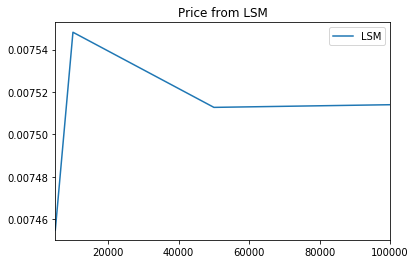

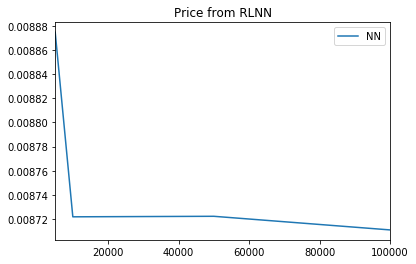

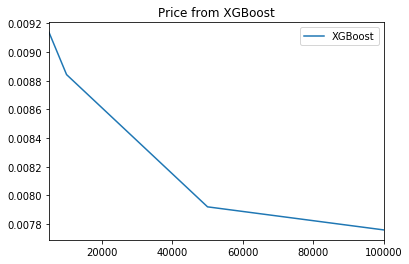

In [186]:
import matplotlib.pyplot as plt

output_table.plot(kind='line',y='LSM',title='Price from LSM')
plt.show()
output_table.plot(kind='line',y='NN',title='Price from RLNN')
plt.show()
output_table.plot(kind='line',y='XGBoost',title='Price from XGBoost')
plt.show()

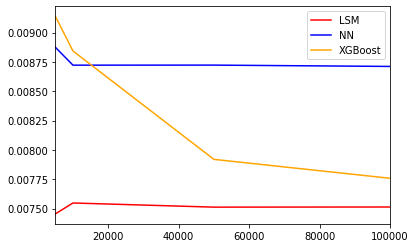

In [187]:
ax=plt.gca()
output_table.plot(kind='line',y='LSM',color='red',ax=ax)
output_table.plot(kind='line',y='NN',color='blue',ax=ax)
output_table.plot(kind='line',y='XGBoost',color='orange',ax=ax)

#### NN will always generate bigger values than LSM and XGBoost do, also it converges faster than XGBoost, in order to see the number of paths that XGBoost nees to converge, we built another 200,000 paths  sim_rates and plot the results.

In [182]:
output_table.to_csv('output_008_1028.csv',index=False)

In [188]:
sim_rates_200k=smm(DFT, corr, 200000, len(para),para)

In [189]:
%%time
prc_xgb_200k=Bermudan_swaption_xgboost(lockout,maturity,sim_rates_200k,strike,seed)

Wall time: 3min 3s


In [190]:
print_result(prc_xgb_200k)

European swaption pirce: 0.006941238984052226
Bermudan swaption pirce: 0.0076629790206305965
Excercise Probability Table
    Time_step  ex_prob_Euro  ex_prob_xgb
0           2      0.707445     0.596225
1           3      0.000000     0.065720
2           4      0.000000     0.027560
3           5      0.000000     0.013035
4           6      0.000000     0.008830
5           7      0.000000     0.006445
6           8      0.000000     0.004370
7           9      0.000000     0.003400
8          10      0.000000     0.002800
9          11      0.000000     0.002720
10         12      0.000000     0.002685
11         13      0.000000     0.002765
12         14      0.000000     0.003325
13         15      0.000000     0.003355
14         16      0.000000     0.003660
15         17      0.000000     0.004815
16         18      0.000000     0.005790
17         19      0.000000     0.007890


In [191]:
xgb_series=np.append(output_table['XGBoost'].values,prc_xgb_200k[1])
path_series=np.append(output_table.index,200000)

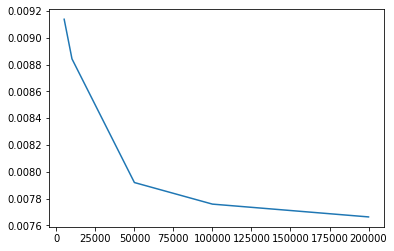

In [192]:
plt.plot(path_series,xgb_series)

####  XGBoost model seems to converge after 100,000 paths, though it's still decreasing.